In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from processing import general_processing
import librosa

In [ ]:
audio_dt = pd.read_pickle('data/imported_audio.pkl')
audio_dt = audio_dt[audio_dt.esc10].reset_index(drop=True)

In [ ]:
audio_dt = general_processing(audio_dt)

## Plot the followings:
- Historgram of each coefficient for each class
- Random plot of N classes

In [ ]:
dict_category = {}
for i, row in audio_dt.iterrows():
    try:
        dict_category[row['category']]
    except:
        dict_category[row['category']] = pd.DataFrame()
    
    dict_category[row['category']] = pd.concat([dict_category[row['category']], row['audio'].x_df])

In [ ]:
dict_category.keys()

In [ ]:
# for k, v in dict_category.items():
#     v.plot.density(subplots=True, layout=(2,7), figsize=(18, 6), sharex=False, sharey=False, title=k)
#     plt.tight_layout()

## This plot does not really show me a lot

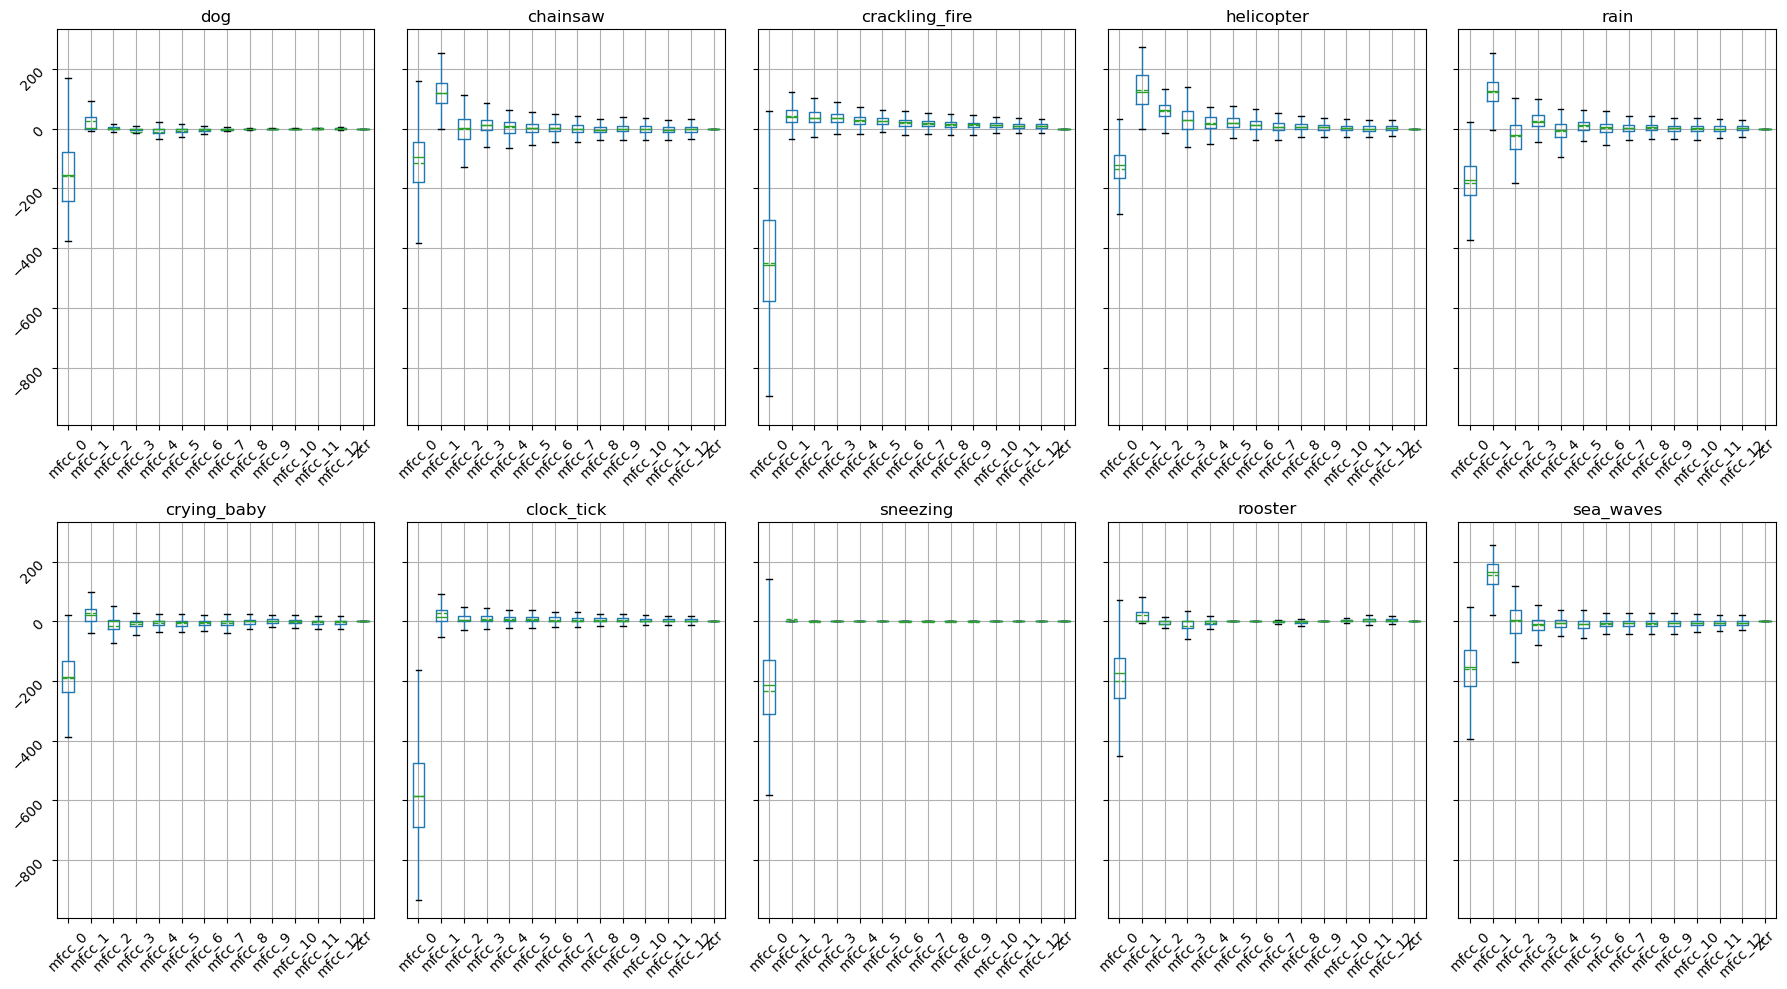

In [70]:
fig, axs = plt.subplots(2, 5, figsize=(18, 10), sharey=True)
ax_flatten = axs.flatten()
for i, k in enumerate(dict_category.keys()):
    dict_category[k].boxplot(ax=ax_flatten[i], showfliers=False, showmeans=True, meanline=True)
    ax_flatten[i].title.set_text(k)
    ax_flatten[i].tick_params(labelrotation=45)

plt.tight_layout()


From this plot we can already see that for some classes some frequencies are not very important, I am also doubting to take into consideration the first mfcc since it is the loudness coefficient (and this I guess it depends on how close the microphone is I guess)

In [71]:
dict_coeff = {}
for k, v in dict_category.items():
    for coeff in v.columns:
        try:
            dict_coeff[coeff]
        except:
            dict_coeff[coeff]=pd.DataFrame()

        coeff_output = v[[coeff]].rename(columns={coeff: k}).reset_index(drop=True)
        dict_coeff[coeff] = pd.concat([dict_coeff[coeff], coeff_output], axis=1)

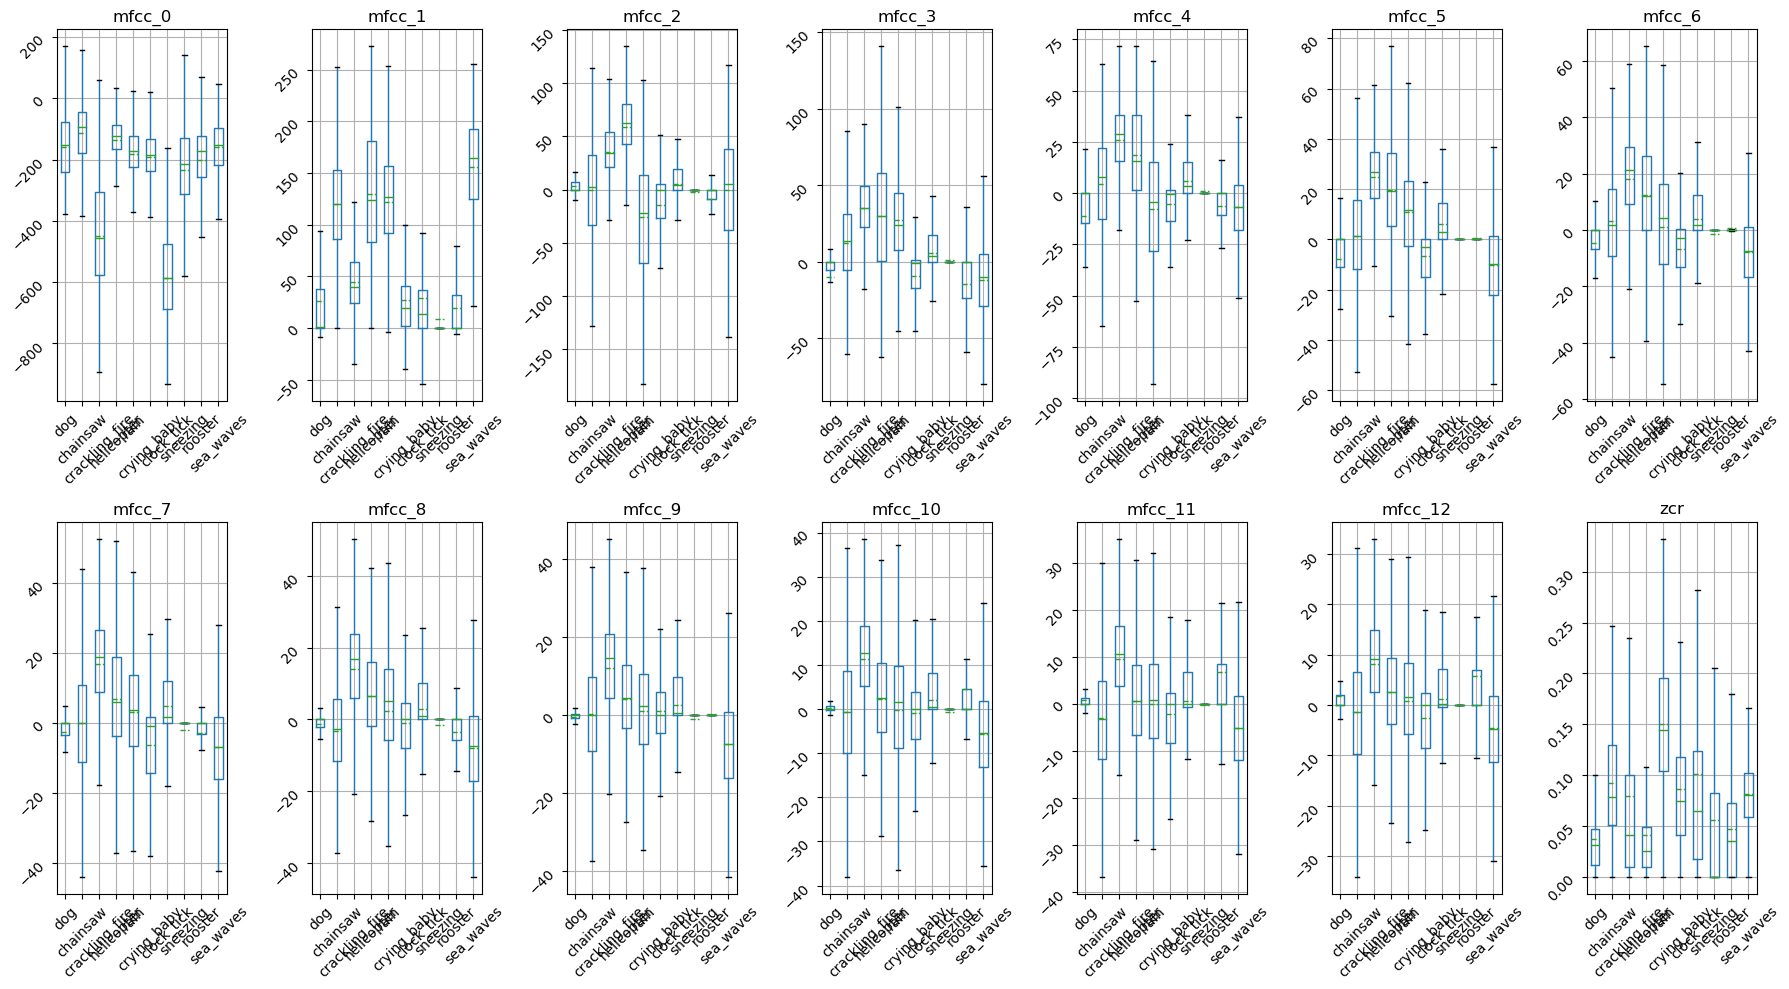

In [72]:
fig, axs = plt.subplots(2, 7, figsize=(18, 10), sharey=False)
ax_flatten = axs.flatten()
for i, k in enumerate(dict_coeff.keys()):
    dict_coeff[k].boxplot(ax=ax_flatten[i], showfliers=False, showmeans=True, meanline=True)
    ax_flatten[i].title.set_text(k)
    ax_flatten[i].tick_params(labelrotation=45)

plt.tight_layout()

In this plot we already see that some categories can be distibguished.

In [89]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], facecolor='w')

In [107]:
def plot_clip_overview(clip, ax, category):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(category, clip.filename), {'fontsize': 8}, y=1.03)
        
        librosa.display.specshow(clip.logamplitude, sr=clip.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)


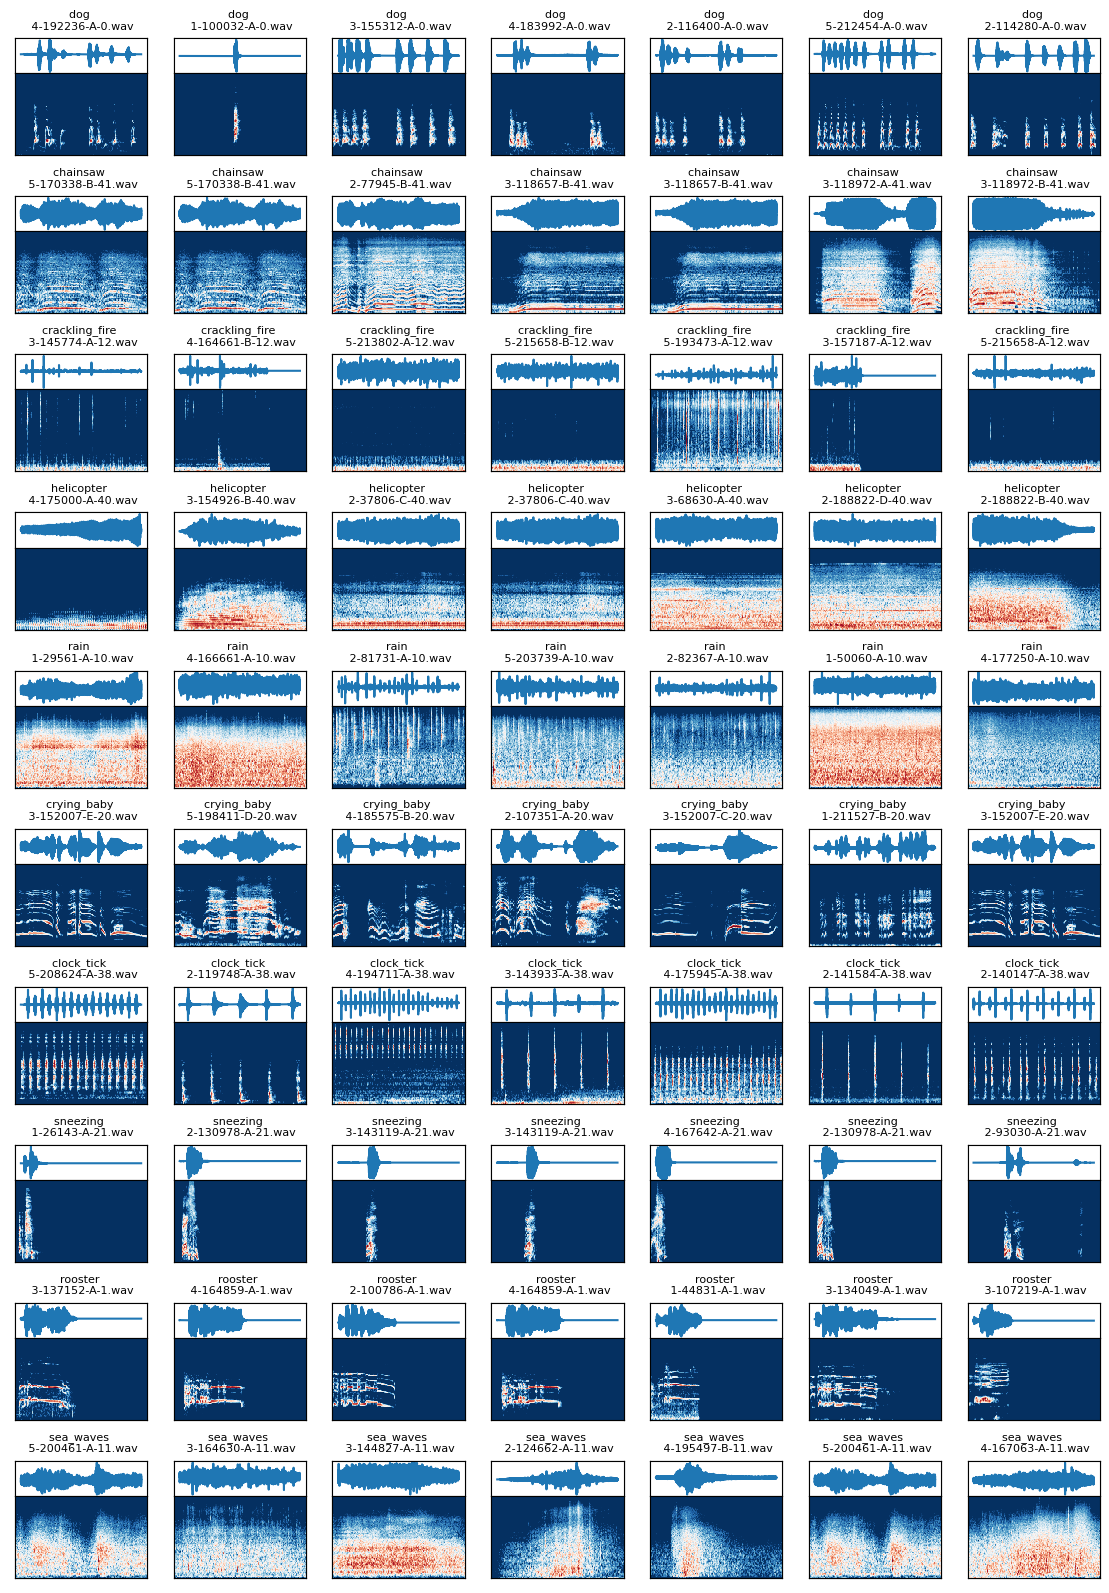

In [108]:

categories = audio_dt.category.unique()
clips_shown = 7
f, axes = plt.subplots(len(categories), clips_shown, figsize=(clips_shown * 2, len(categories) * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c, cat in enumerate(categories):
    plot_dt = audio_dt[audio_dt.category == cat].reset_index(drop=True)
    random_list = [random.randint(0,(plot_dt.shape[0] - 1)) for i in range(clips_shown)]
    plot_dt = plot_dt.iloc[random_list]
    for i, audio in enumerate(plot_dt.audio):
        plot_clip_overview(audio, axes[c, i], cat)

Here we see interesting patterns, for instance that there are certain sounds that tend to have very ripetitive sounds while other ones are an always on sound.
This shows to me that is not only the frequency that is important but also the slope of the presence of a particular frequency that will be important